In [1]:
# if env not work: pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 xformers -f https://download.pytorch.org/whl/torch_stable.html
# install other dependencies manually
# might need to downgrade numpy to 1.24 or so

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from einops import rearrange
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE


class DataData(Dataset):
    def __init__(self, root_dir="./cat_dog", image_size=224):
        
        path = Path(root_dir)
        self.data_path = list(path.rglob("*.[jp][pn]g"))

        self.image_size = image_size


    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):

        image_path = self.data_path[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except:
            print("error")
            return torch.zeros((3, self.image_size, self.image_size))
        image = image.resize((self.image_size, self.image_size), Image.BILINEAR)


        image = np.array(image).astype(float)
        image /= 255

        image = torch.tensor(image)

        image = rearrange(image, 'h w c -> c h w')
        
        image = image.to(torch.float32)

        return image, torch.tensor(1) if "cat" in str(image_path.stem) else torch.tensor(0)

In [2]:
dataset = DataData(image_size=224)

def collate_fn(batch):
    images = []
    labels = []
    for img, label in batch:
        images.append(img)
        labels.append(label)
    return torch.stack(images), torch.stack(labels)

val_loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=32, collate_fn=collate_fn)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
def get_num_params(model):
    # numel: num elements in tensor
    return sum([param.numel() for param in model.parameters() if param.requires_grad])

def calculate_model_size(model, float_precision=32):
    float_size_bytes = float_precision // 8  # 4 bytes for 32-bit float precision
    num_params = get_num_params(model)
    size_in_bytes = num_params * float_size_bytes
    size_in_mb = size_in_bytes / (1024 ** 2)
    return size_in_mb

In [4]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)

Using cache found in /home/agesp/.cache/torch/hub/facebookresearch_dinov2_main
/home/agesp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/agesp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/agesp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [5]:
calculate_model_size(model)

84.13916015625

In [6]:
# Extract features using the dyno model
with torch.no_grad():
    features = []
    labels = []
    for i, (image, label) in enumerate(tqdm(val_loader)):
        image = image.to(device)
        encoded = model(image)
        features.append(encoded.view(encoded.size(0), -1).cpu().numpy())
        labels.append(label)
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

100%|██████████| 10/10 [00:00<00:00, 12.03it/s]


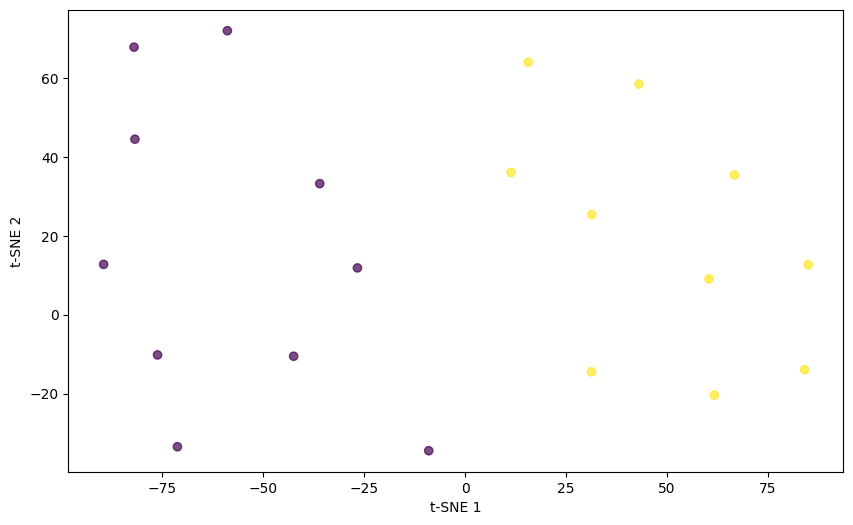

In [7]:
tsne = TSNE(n_components=2, perplexity=10, learning_rate=100)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(10, 6))
plot = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=plt.get_cmap('viridis', 2), alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [40]:
import io
import base64

from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go
import json
from PIL import Image

import numpy as np


def np_image_to_base64(im_matrix):
    im = Image.fromarray(im_matrix)
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image
    return im_url

images = dataset
labels = labels

scatter = go.Scatter(
    x=tsne_features[:, 0],
    y=tsne_features[:, 1],
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.7,
        'color': [label.item() for _, label in dataset],
        'colorscale': 'Viridis',   # choose a colorscale
    }
)

fig = go.Figure(data=[scatter])

fig.update_traces(
    hoverinfo="none",
    hovertemplate=None,
)

layout = go.Layout(
    autosize=False,
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=1200,
    height=1200
)

fig = go.Figure(data=[scatter], layout=layout)


styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}

app = Dash(__name__)

app.layout = html.Div(
        className="container",
        children=[
            dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
            dcc.Input(id="file_name", value='bars.txt', type='text'),
            html.Button('Save datapoints to file', id='button'),
        ],
       
)

origin = {
    1: "cat",
    0: "dog",
}

@callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

    im_matrix = rearrange((dataset[num][0].numpy() * 255).astype(np.uint8), "c h w -> h w c")
    im_url = np_image_to_base64(im_matrix)
    children = [
        html.Div([
            html.Img(
                src=im_url,
                style={"width": "300px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P("Origin " + origin[dataset[num][1].item()], style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children


# @callback(
#     inputs=[Input('button', 'n_clicks')],
#     state=[State(component_id='file_name', component_property='value'), State('graph-5', 'selectedData')],
# )
# def display_selected_data(n_clicks, file_name, selectedData):
#     if selectedData is None:
#         return
#     img_paths = [str(eval_dataset.combined_images_list[point["pointIndex"]]) for point in selectedData["points"]]
#     with open(file_name, "a+") as f:
#         f.write("\n".join(img_paths) + "\n")


app.run_server(jupyter_mode="tab", port=8059)

Dash app running on http://127.0.0.1:8059/


<IPython.core.display.Javascript object>

In [11]:
import plotly.express as px
from PIL import Image
import torchvision.transforms.functional as F


i = 0
images = []

idxs = range(0, len(dataset), 1)
fig = px.scatter(x=tsne_features[:, 0][idxs], y=tsne_features[:, 1][idxs], width=1500, height=1200)

x = []
y = []

for idx in idxs:
    images.append(dataset[idx][0])
for x,y, png in zip(fig.data[0].x, fig.data[0].y, images):

    fig.add_layout_image(
        x=x,
        y=y,
        source=F.to_pil_image(png),
        xref="x",
        yref="y",
        sizex=12,
        sizey=12,
        xanchor="center",
        yanchor="middle",
    )

fig    